In [1]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
from scipy.special import legendre

# Problem Set 2
## Alex Laroche (260854146)

## Problem 1

The electric field, in units of $q(4\pi\epsilon_0)^{-1},$ is given by

$$E(z) = \frac{1}{2}\int_{-1}^1 \frac{z-Ru}{(R^2+z^2-2Rzu)^{3/2}}du.$$

In [2]:
func = lambda u,z,R: 0.5*(z-R*u)/(R**2+z**2-2*R*z*u)**(3/2) #function to integrate

#Code taken from Jon's lecture notes

def integrator(func,xi,xf,dx,order=2,args=None):
    '''
    Return integral of func from xi to xf using Legendre polynomials
    
    :param func: integrand
    :param xi,xf: float integral start/end points
    :param dx: float desired step size
    :param order: int Legendre polynomial order
    :param args: list function arguments, if applicable
    '''
    coeffs=integration_coeffs_legendre(order+1) #Legendre integration coefficients
    npt=int((xf-xi)/dx)+1 #number of points
    nn=(npt-1)%order
    if nn>0: npt+=(order-nn) #adjust number of points if necessary
    assert(npt%order==1) #enforce odd number of points
    
    x=np.linspace(xi,xf,npt)
    dx=np.median(np.diff(x)) #median dx of x
    if args==None: fx=func(x) #no params
    else: fx=func(x,*args) #function with params
    mat=np.reshape(fx[:-1],[int((npt-1)/order),order]).copy() #f(x) matrix
    mat[0,0]+=fx[-1] #add first and last points
    mat[1:,0]*=2 #points which are used in two bins are weighted accordingly
    
    vec=np.sum(mat,axis=0) #sum columns
    return np.sum(vec*coeffs[:-1])*dx
    
def legendre_mat(n):
    '''
    Return nxn Legendre polynomial matrix
    
    :param n: int order
    '''
    x=np.linspace(-1,1,n)
    mat=np.zeros([n,n])
    mat[:,0]=1.
    mat[:,1]=x
    if n>2:
        for i in range(1,n-1):
            mat[:,i+1]=((2.*i+1)*x*mat[:,i]-i*mat[:,i-1])/(i+1.)
    return mat

def integration_coeffs_legendre(n):
    '''
    Return n Legendre integration coefficients
    
    :param n: int order
    '''
    mat=legendre_mat(n)
    mat_inv=np.linalg.inv(mat)
    coeffs=mat_inv[0,:]
    coeffs*=(n-1.)/coeffs.sum()
    return coeffs

<ipython-input-2-3ab8c8ac1331>:1: RuntimeWarning: invalid value encountered in true_divide
  func = lambda u,z,R: 0.5*(z-R*u)/(R**2+z**2-2*R*z*u)**(3/2) #function to integrate


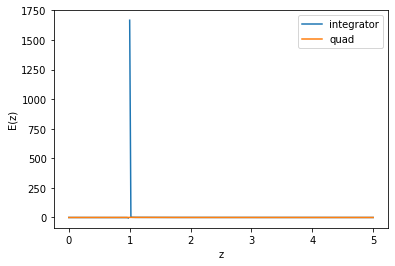

In [5]:
R=1
xi,xf=-1,1
z1=np.linspace(1e-3,R,50)
z2=np.linspace(R+1e-3,5,200)
z=np.concatenate((z1,z2))
dx=0.01

int1=np.array([integrator(func,xi,xf,dx,args=(zi,R)) for zi in z])
int2=np.array([quad(func,xi,xf,args=(zi,R))[0] for zi in z])

plt.plot(z,int1,label='integrator')
plt.plot(z,int2,label='quad')
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()

There is a singularity at $z=R.$ $\texttt{integrator}$ is affected by the singularity and $\texttt{quad}$ is not. Let's eliminate the bad points and see if they agree.

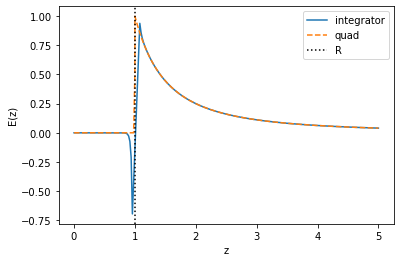

In [6]:
int1_mod = int1[(int1!=np.nan) & (np.abs(int1) <= 1)]
z_mod = z[(int1!=np.nan) & (np.abs(int1) <= 1)]

plt.plot(z_mod,int1_mod,label='integrator')
plt.plot(z,int2,label='quad',ls='--')
plt.axvline(1,color='k',ls=':', label='R')
plt.xlabel('z')
plt.ylabel('E(z)')
plt.legend()
plt.show()

The functions agree for radii which are sufficiently far away from the shell where the singularity occurs.

## Problem 2

In [15]:
def lazy_integrate_adaptive(fun,a,b,tol):
    '''
    Returns integral using adaptive integrator from lecture
    
    :param fun: integrand
    :param a,b: integration bounds
    :param tol: error tolerance
    '''
    x=np.linspace(a,b,5)
    y=fun(x)
    dx=(b-a)/(len(x)-1)
    area1=2*dx*(y[0]+4*y[2]+y[4])/3
    area2=dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3
    err=np.abs(area1-area2)
    if err<tol: 
        return area2
    else:
        c=(a+b)/2
        left=lazy_integrate_adaptive(fun,a,c,tol/2)
        right=lazy_integrate_adaptive(fun,c,b,tol/2)
        return left+right

def areas(y,dx):
    '''
    Return areas using 3 and 5 points
    
    :param y: array of 5 y values
    :param dx: distance between points
    '''
    area1=2*dx*(y[0]+4*y[2]+y[4])/3
    area2=dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3
    return area1,area2

def integrate_adaptive(fun,a,b,tol,extra=None):
    '''
    Returns integral using adaptive integration without evaluating points twice
    
    :param fun: integrand
    :param a,b: integration bounds
    :param tol: error tolerance
    :param extra: specifies first step (None) or provides f(x) values as an array for subsequent steps
    '''
    global counter
    if extra is None: #first step
        x=np.linspace(a,b,5)
        y=fun(x)
        dx=(b-a)/(len(x)-1)
        area1,area2=areas(y,dx)
        if np.abs(area1-area2)<tol: #check if tolerance is satisfied
            return area2
        else:
            c=x[2] #midpoint
            #give left calculation first 3 f(x) values and right calculation final 3 f(x) values
            return integrate_adaptive(fun,a,c,tol,extra=y[:-2])+integrate_adaptive(fun,c,b,tol,extra=y[2:])
    if extra is not None: #subsequent steps
        x=np.linspace(a,b,5)
        y=np.empty(len(x))
        y[::2]=extra #use previously evaluated f(x)
        counter+=len(extra) #count number of saved function calls
        y[1::2]=fun(x[1::2]) #compute new f(x)
        dx=(b-a)/(len(x)-1)
        area1,area2=areas(y,dx)
        if np.abs(area1-area2)<tol:
            return area2
        else:
            c=(a+b)/2
            return integrate_adaptive(fun,a,c,tol,extra=y[:-2])+integrate_adaptive(fun,c,b,tol,extra=y[2:])

In [16]:
from IPython.display import display, Latex

###Integrate sin(x) from 0 to pi
fun=np.sin
a,b=0,np.pi
tol=1e-6
targ=2

#Lazy way
integral=lazy_integrate_adaptive(fun,a,b,tol)
display(Latex(r'Lazy error $\left(\int_0^\pi \sin(x)\,dx\right)=$'
              +"{:.2e}".format(np.abs(integral-targ))))

#Save function calls
counter=0
integral=integrate_adaptive(fun,a,b,tol)
print('We saved %s function calls' %counter)
display(Latex(r'Efficient error$\left(\int_0^\pi \sin(x)\,dx\right)=$'
              +"{:.2e}".format(np.abs(integral-targ))))

###Integrate exp(x) from -1 to 1
fun=np.exp
a,b=0,1
tol=1e-6
targ=np.e-1

#Lazy way
integral=lazy_integrate_adaptive(fun,a,b,tol)
display(Latex(r'Lazy error $\left(\int_0^1 e^x\,dx\right)=$'
              +"{:.2e}".format(np.abs(integral-targ))))

#Save function calls
counter=0
integral=integrate_adaptive(fun,a,b,tol)
print('We saved %s function calls' %counter)
display(Latex(r'Efficient error $\left(\int_0^1 e^x\,dx\right)=$'
              +"{:.2e}".format(np.abs(integral-targ))))

<IPython.core.display.Latex object>

We saved 78 function calls


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We saved 18 function calls


<IPython.core.display.Latex object>

$\texttt{integrate_adaptive}$ does indeed save many function calls. The errors in comparison to $\texttt{lazy_integrate_adaptive}$ are higher, but they still satisfy the inputted $10^{-6}$ tolerance.

## Problem 3

In [17]:
from numpy.polynomial.chebyshev import chebfit,chebval
from numpy.polynomial.legendre import legfit,legval

def chebcoeffs(func,a,b,acc,deg=20):
    '''
    Returns minimal number of Chebyshev coefficients to model func on interval [a,b]
    with desired accuracy.
    
    :param func: function to fit
    :param a,b: fit bounds
    :param acc: float desired accuracy
    :param deg: int large degree to compute up to
    '''
    x=np.linspace(a,b,int(1e4))
    y=func(x)
    xs=2*(x-a)/(b-a)-1 #map [a,b] to [-1,1]
    coeffs=chebfit(xs,y,deg)
    for i in range(1,deg-1):
        err=np.sum(coeffs[deg+1-i:]) #error is sum of dropped coefficients
        if err>acc:
            return coeffs[:-(i-1)] #returns minimal coeffs for desired accuracy

def mylog2(x):
    '''
    Returns natural log of x using Chebyshev coeffs
    
    :param x: positive number
    '''
    assert(x>0) #positive
    mant,exp=np.frexp(x) #x=mant*2**exp
    coeffs=chebcoeffs(np.log2,0.5,1,1e-6) 
    mant_scale=2*(mant-0.5)/0.5-1 #scale mantissa to [-1,1]
    log2_mant=chebval(mant_scale,coeffs)
    ln_x=(exp+log2_mant)/np.log2(np.e)
    return ln_x

def legcoeffs(func,a,b,deg):
    '''
    Returns coefficients for input degree Legendre polynomial to fit func on [a,b]
    
    :param func: function to fit
    :param a,b: fit bounds
    :param deg: int Legendre order
    '''
    x=np.linspace(a,b,int(1e4))
    y=func(x)
    xs=2*(x-a)/(b-a)-1
    return legfit(xs,y,deg)

def mylog2_leg(x,deg):
    '''
    Returns natural log of x using Legendre coeffs
    
    :param x: positive number
    '''
    assert(x>0) #positive
    mant,exp=np.frexp(x)
    coeffs=legcoeffs(np.log2,0.5,1,deg)
    mant_scale=2*(mant-0.5)/0.5-1 #scale mantissa to [-1,1]
    log2_mant=legval(mant_scale,coeffs)
    ln_x=(exp+log2_mant)/np.log2(np.e) #did not fit for log2(e)
    return ln_x

The natural log is evaluated in the following way:
    
$$\begin{align*}
    \ln(x) = \ln(m2^n)
    = \frac{n+\log_2(m)}{\log_2(e)}.
\end{align*}$$

Let's compare the Chebyshev and Legendre polynomials for computing $\ln(x).$

Chebyshev RMSE is 1.332099489471858e-07 and max error is 2.1821895490603538e-07
Legendre RMSE is 1.1543025545306505e-07 and max error is 5.157447571235707e-07


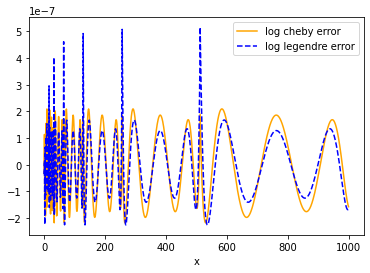

In [18]:
x=np.linspace(1e-1,1e3,1000)

deg=len(chebcoeffs(np.log2,0.5,1,1e-6))-1
logs_cheb=[mylog2(xi) for xi in x]
logs_leg=[mylog2_leg(xi,deg) for xi in x]

RMSE_cheb=np.sqrt(np.sum((logs_cheb-np.log(x))**2)/len(x))
RMSE_leg=np.sqrt(np.sum((logs_leg-np.log(x))**2)/len(x))
max_cheb=np.max(np.abs(logs_cheb-np.log(x)))
max_leg=np.max(np.abs(logs_leg-np.log(x)))

print('Chebyshev RMSE is %s and max error is %s' %(RMSE_cheb,max_cheb))
print('Legendre RMSE is %s and max error is %s' %(RMSE_leg,max_leg))
plt.plot(x,logs_cheb-np.log(x),c='orange',label='log cheby error')
plt.plot(x,logs_leg-np.log(x),c='blue',ls='--',label='log legendre error')
plt.xlabel('x')
plt.legend()
plt.show()

The RMSE for both Chebyshev and Legendre are roughly the same, but the max error is lower by more than a factor of 2 when using Chebyshev polynomials.